##Rapid, High-resolution and Distortion-free Fetal Brain R2* Mapping with BART

This tutorial uses the [BART](http://mrirecon.github.io/bart/) command-line inteface (CLI) and presents how to perform nonlinear model-based reconstruction for simultaneous water-fat separation, R2* and B0 mapping of fetal brain using multi-echo radial FLASH at 3 T.

This tutorial is based on the 2021 ISMRM software demo on [Model-based Nonlinear Reconstruction using BART](https://github.com/mrirecon/bart-workshop/blob/master/ismrm2021/model_based/bart_moba.ipynb).

**Main Reference**

Wang X, Fan H, Tan Z, Vasylechko S, Yang E, Didier R, Afacan O, Uecker M, Warfield SK, Gholipour A. [Rapid, High-resolution and Distortion-free R2* Mapping of Fetal Brain using Multi-echo Radial FLASH and Model-based Reconstruction](https://arxiv.org/abs/2501.00256) (Magnetic Resonance in Medicine, DOI: 10.1002/mrm.30604).

**Author**: [Xiaoqing Wang](mailto:xiaoqing.wang@childrens.harvard.edu)

**Institution**: Department of Radiology, Boston Children's Hospital, Harvard Medical School

### 0. Setup BART

#### 0.1 Google colab
The cell will setup BART on Google Colab. For a detailed explanation, see **How to Run BART on Google Colaboratory** in the same [repository](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2021). You can skip this part if you want to run this notebook on your local machine.

This tutorial do need a GPU, you can select one by going to **Edit → Notebook settings**: Choose **GPU** from **Hardware accelerator** drop-down menu.

In [ ]:
%%bash

# Use CUDA 10.1 when on Tesla K80

# Estimate GPU Type
GPU_NAME=$(nvidia-smi --query-gpu=gpu_name --format=csv,noheader)

echo "GPU Type:"
echo $GPU_NAME

if [ "Tesla K80" = "$GPU_NAME" ];
then
    echo "GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1."

    # Change default CUDA to version 10.1
    cd /usr/local
    rm cuda
    ln -s cuda-10.1 cuda
else
    echo "Current GPU supports default CUDA-11."
    echo "No further actions are necessary."
fi

#apt-get update
apt install cuda-toolkit-12-4
cd /usr/local; rm cuda; ln -s cuda-12.4 cuda

echo "GPU Information:"
nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
nvcc --version

In [ ]:
 %%bash

# Install BARTs dependencies
apt-get install -y make gcc-12 libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev

# Clone Bart
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null

In [ ]:
%%bash

cd bart
git checkout efb1de8

#export LD_LIBRARY_PATH=/usr/local/cuda-12.5/targets/x86_64-linux/lib:$LD_LIBRARY_PATH


# Configuration
COMPILE_SPECS=" OPENBLAS=1
                BLAS_THREADSAFE=1
                CUDA=1
                LOCKDIR=/dev/shm/
                PARALLEL?=1
                "

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local
echo "CUDA_BASE=/usr/local/cuda" >> Makefiles/Makefile.local
echo "CUDA_LIB=lib64" >> Makefiles/Makefile.local

# Compile BART
make && echo ok

In [ ]:
import os
import sys

# Define environment variables for BART and OpenMP

os.environ['TOOLBOX_PATH'] = "/content/bart"

os.environ['OMP_NUM_THREADS']="4"

# Add the BARTs toolbox to the PATH variable

os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python")

#### (0.2 Local machine) - OPTIONAL!

Alternatively, this notebook can run on local machines. In this case, we need to define the required environmental variables.

In [ ]:
# import os

# os.environ["TOOLBOX_PATH"] = "/home/xwang/bart"
# os.environ["PATH"] = os.getenv("TOOLBOX_PATH") + os.pathsep + os.getenv("PATH")

#### 0.3 Check BART version

Let us check the installed BART version.

In [ ]:
%%bash

echo "# The BART used in this notebook:"
which bart
echo "# BART version: "
bart version

<a id='download-materials'></a>
### Download Supporting Materials

For this tutorial, we do need several supporting materials (figures, plotting scripts and compressed data for mult-echo radial FLASH). They are stored in the GitHub repository and need to be downloaded.

## 1. Introduction
### 1.1 Multi-echo Radial FLASH

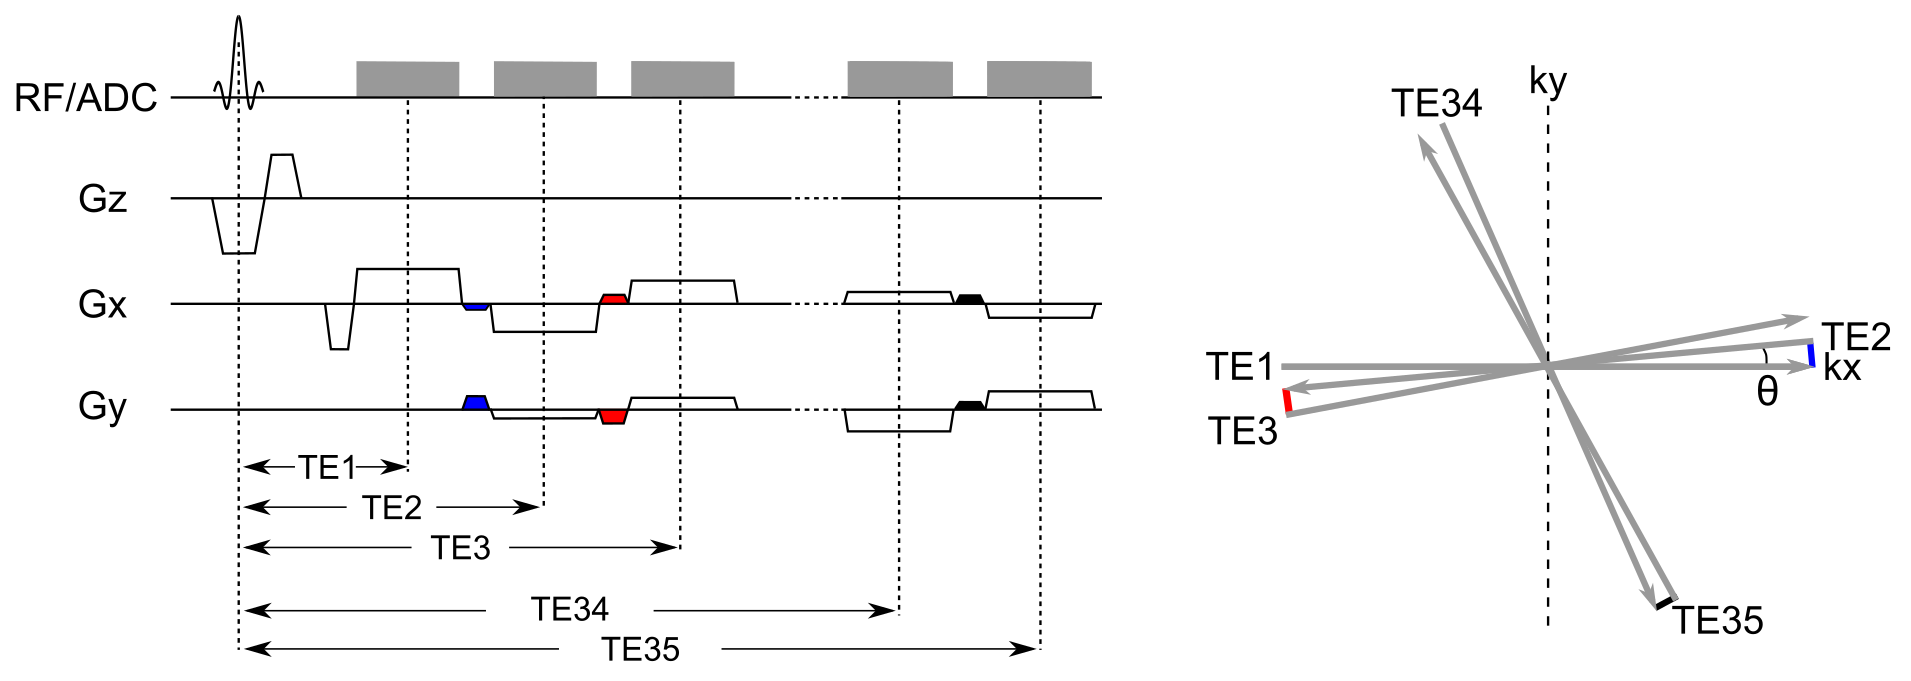

**General Idea of Model-based Reconstruction**:

   Formulating the estimation of MR physical parameters directly from k-space as a nonlinear inverse problem

### 1.2 Operator chain of parallel imaging and MR signal model (nonlinear)

<img src="https://github.com/mrirecon/bart-workshop/blob/master/ismrm2021/model_based/operator_chain.png?raw=1" style="width: 400px;">

$$F: x \mapsto y = {\mathcal{P} \mathcal{F} C} \cdot {M(x_{p})}$$
- $\mathcal{P}$ - sampling pattern
- $\mathcal{F}$ - Fourier transform
- $C$ - coil sensitivity maps
- $M(\cdot)$ - MR physics model
- $x_{p}$ - MR parameters
- $y$ - acquired kspace data

### 1.3 Optimization

We use the iteratively regularized Gauss-Newton method (IRGNM) in BART to solve the nonlinear inverse problem

$$\hat{x} = \text{argmin}_{x}\|F(x) -y\|_{2}^{2} + \lambda \cdot R(x), $$

i.e., the nonlinear problem can be linearly solved in each Gauss-Newton step:

$$\hat{x}_{n+1}= \text{argmin}_{x}\|DF(x_{n})(x−x_{n}) +F(x_{n})−y\|_{2}^{2} + \lambda \cdot R(x)$$

$DF(x_{n})$ is the Jacobian matrix of $F$ at the point $x_{n}$ of the $n$th Newton step.

---

As can be seen, model-based reconstruction directly estimates the MR parameter maps from undersampled k-space datasets. No pixel-wise fitting or intermediate reconstruction of contrast-weighted images is required!

For further information, feel free to check this review paper:

[Wang X](mailto:xiaoqingwang2010@gmail.com), Tan Z, Scholand N, Roeloffs V, Uecker M.  
[Physics-based Reconstruction Methods for Magnetic Resonance Imaging](https://royalsocietypublishing.org/doi/10.1098/rsta.2020.0196).  
Philos Trans R Soc A 379 (2200), 20200196.

### 1.4 BART Commands

The nonlinear model-based reconstruction can be performed using the `moba` command in BART. It now supports T1, T2, water-fat and T2* mapping.

In [ ]:
%%bash

#### moba now supports T1, T2, water-fat and T2* mapping
bart moba -h

## 2. Data Preparation and Reconstruction

The data preparation part has been explained before in detail in the [3rd event of the BART webinar series](https://github.com/mrirecon/bart-webinars/tree/master/webinar3). It mainly contains the following four steps:

2.1 Download raw data  
2.2 Coil compression  
2.3 Prepare radial trajectory, data and run model-based reconstruction

#### 2.1 Download Raw Data

In [ ]:
%%bash

## Download raw data
name=ksp_cc

wget https://github.com/IntelligentImaging/FetalR2Star/raw/main/fetal_data/subject3/${name}.hdr
wget https://github.com/IntelligentImaging/FetalR2Star/raw/main/fetal_data/subject3/${name}.cfl

head -n2 ${name}.hdr

#### 2.2 Coil Compression

In [ ]:
%%bash

## Coil compression

# number of virtual coils
NUM_VCOILS=8 # for the purpose of fast computation, for better performance, 12 is recommended.
# coil compression
bart cc -A -p $NUM_VCOILS ksp_cc ksp_cc2

#### 2.3 Prepare Radial Trajectory, Data and Run Model-based Reconstruction

In [ ]:
%%bash

# Download the bash scripts
wget https://github.com/IntelligentImaging/FetalR2Star/raw/main/prep.sh
wget https://github.com/IntelligentImaging/FetalR2Star/raw/main/reco.sh


#apt-get update
apt-get install -y bc

#parameters for image reconstruction
cat ksp_cc2.hdr
data=ksp_cc2
READ=$(bart show -d0 $data)
ne=35 # number of echos
TR=68500
GA=2
lambda=0.002
SPOKES=30 # no. of TRs
nframe=1 # total number of k-space frames
fB0_a=22
fB0_b=4
newton=15
overgrid=1.5
NBR=$((READ / 2))
scaling_R2s=0.05
scaling_fB0=0.05
scaling_fB0_HZ=$(echo "scale=4; $scaling_fB0*1000" | bc)
SLICES2=1

## Preparing traj, data, TI and TE
bash prep.sh -E$ne -T$TR -G$GA -s$SLICES2 -f$SPOKES $data data_2D_35e traj_2D_35e TI_2D_35e TE_2D_35e

bart ones 6 1 1 1 1 1 1 TI

# ## Model-based reconstruction
bash reco.sh -I -R$lambda -a$fB0_a -b$fB0_b -i$newton -o$overgrid -s$scaling_R2s -S$scaling_fB0 TI TE_2D_35e traj_2D_35e \
	data_2D_35e reco_moba_reg${lambda}_np${SPOKES} sens_moba_reg${lambda}_np${SPOKES}

## 3. Results



#### 3.1 Visualize Results

Following reconstruction, we resize the reconstructed maps to their original size (to remove the oversampling effect). Moreover, we extract each individual map from the output and place them next to each other for better visualization.

In [ ]:
## Resize and Display the reconstructed maps, i.e., (Water, fat, R2sar, B0)
!bart resize -c 0 224 1 224 reco_moba_reg0.002_np30 reco_moba_reg0.002_np30_224
!bart show -m reco_moba_reg0.002_np30_224
!bart transpose 0 1 reco_moba_reg0.002_np30_224 tmp
!bart flip $(bart bitmask 1) tmp tmp2
!bart slice 6 0 tmp2 Water
!bart slice 6 1 tmp2 fat
!bart slice 6 2 tmp2 r2star
!bart slice 6 3 tmp2 b0

!bart resize -c 0 224 1 224 sens_moba_reg0.002_np30 sens_moba_reg0.002_np30_224
!bart rss $(bart bitmask 3) sens_moba_reg0.002_np30_224 sens_moba_reg0.002_np30_224_rss
!bart transpose 0 1 sens_moba_reg0.002_np30_224_rss tmp
!bart flip $(bart bitmask 1) tmp tmp2
!bart fmac Water tmp2 Water_rss
!bart fmac fat tmp2 fat_rss
!bart scale 5e1 Water_rss Water_rss2
!bart scale 5e1 fat_rss fat_rss2

!bart join 1 Water_rss2 fat_rss2 r2star b0 tmp
!bart flip $(bart bitmask 0) tmp maps_all

!bart toimg -W maps_all maps_all.png

from IPython.display import Image
Image("maps_all.png", width=1000)

The outputs of the nonlinear model-based reconstruction are: Water, Fat, R2* and B0 (from left to right).  
Finally, we can use the show the color-coded quantitative R2* and B0 maps.

In [ ]:
## export R2* map
!wget https://github.com/IntelligentImaging/FetalR2Star/raw/main/utils/save_maps.py
!wget https://github.com/IntelligentImaging/FetalR2Star/raw/main/utils/cfl.py

!bart flip $(bart bitmask 0) r2star r2star0
!bart extract 0 32 126 1 32 126 r2star0 r2star_crop
# !bart flip $(bart bitmask 0) tmp moba_T1map
!python3 save_maps.py r2star_crop magma 0 30 r2star_crop.png
Image("r2star_crop.png", width=200)

In [ ]:
## export B0 map
!bart flip $(bart bitmask 0) b0 b0_0
!bart extract 0 32 126 1 32 126 b0_0 b0_0_crop
# !bart flip $(bart bitmask 0) tmp moba_T1map
!python3 save_maps.py b0_0_crop RdBu_r -50 50 b0_0_crop.png
Image("b0_0_crop.png", width=200)

In [ ]:
%%bash

## Synthesize R2*-weighted images

TE=(10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000)
length=${#TE[@]}
bart ones 6 1 1 1 1 1 1 tmp1.coo
n=0
for i in ${TE[@]};
do
        bart scale $i tmp1.coo tmp2-${n}
        n=$((n+1))
done

bart join 5 $(seq -f "tmp2-%g" 0 $(($length-1))) TE2

bart scale 1e-3 TE2 tmp-TE1
bart transpose 5 9 tmp-TE1 TE2_2

bart fmac TE2_2 r2star_crop r2star_te
bart scale -- -1e-3 r2star_te r2star_te2

bart zexp r2star_te2 zexp2_r2star
bart show -m zexp2_r2star
bart extract 9 3 4 zexp2_r2star zexp2_r2star_TE_40ms
bart extract 9 6 7 zexp2_r2star zexp2_r2star_TE_70ms
bart extract 9 11 12 zexp2_r2star zexp2_r2star_TE_120ms

bart join 1 zexp2_r2star_TE_40ms zexp2_r2star_TE_70ms zexp2_r2star_TE_120ms r2star_weighted

bart scale 5e2 r2star_weighted r2star_weighted2
bart toimg -w50 r2star_weighted2 r2star_weighted.png

In [ ]:
## Display R2*-weighted images at three TEs (40 ms, 70 ms, 120 ms, from left to right)
from IPython.display import Image
Image("r2star_weighted.png", width=700)

#### 3.2 Comparison to reference methods (optional)

For further comparison, the same radial data can also be reconstructed using CG-SENSE or Parallel Imaging and Compressed Sensing (PICS) with BART (image-space method)

In [ ]:
%%bash
## Coil estimation by ESPIRiT (from the first echo)
overgrid=1.5
bart extract 9 0 1 data_2D_35e data_2D_35e_e1
bart extract 9 0 1 traj_2D_35e traj_2D_35e_e1

bart scale $overgrid traj_2D_35e_e1 traj2_tmp
bart nufft -i -g traj2_tmp data_2D_35e_e1 nufft_e1
bart fft -u 3 nufft_e1 ke_grid2

bart ecalib -m1 ke_grid2 sens
bart rss $(bart bitmask 3) sens sens_rss

## CG-SENSE
bart scale $overgrid traj_2D_35e traj2_tmp2
bart pics -g -i50 -t traj2_tmp2 data_2D_35e sens recon_CG_SENSE
bart fmac recon_CG_SENSE sens_rss recon_CG_SENSE_rss
bart resize -c 0 224 1 224 recon_CG_SENSE_rss recon_CG_SENSE_224

## PICS
lambda=0.002
bart pics -g -i200 -R W:$(bart bitmask 0 1):$(bart bitmask 9):$lambda -R T:$(bart bitmask 9):0:0.001 -t traj2_tmp2 \
data_2D_35e sens recon_pics_reg$lambda
bart fmac recon_pics_reg$lambda sens_rss recon_pics_reg${lambda}_rss
bart resize -c 0 224 1 224 recon_pics_reg${lambda}_rss recon_pics_reg${lambda}_224

## Display example CG-SENSE and PICS images at later TEs
bart extract 9 34 35 recon_CG_SENSE_224 recon_CG_SENSE_224_TE34
bart extract 9 34 35 recon_pics_reg${lambda}_224 recon_pics_reg${lambda}_224_TE34

bart transpose 1 0 recon_CG_SENSE_224_TE34 tmp_CG
bart transpose 1 0 recon_pics_reg${lambda}_224_TE34 tmp_pics

bart flip $(bart bitmask 0) tmp_CG tmp_CG2
bart flip $(bart bitmask 0) tmp_pics tmp_pics2

bart flip $(bart bitmask 1) tmp_CG2 recon_CG_SENSE_224_TE34_2
bart flip $(bart bitmask 1) tmp_pics2 recon_pics_reg${lambda}_224_TE34_2

bart extract 0 32 126 1 32 126 recon_CG_SENSE_224_TE34_2 recon_CG_SENSE_224_TE34_crop
bart extract 0 32 126 1 32 126 recon_pics_reg${lambda}_224_TE34_2 recon_pics_reg${lambda}_224_TE34_crop

bart scale 2e1 recon_CG_SENSE_224_TE34_crop recon_CG_SENSE_224_TE34_crop2
bart scale 2e1 recon_pics_reg${lambda}_224_TE34_crop recon_pics_reg${lambda}_224_TE34_crop2
bart join 1 recon_CG_SENSE_224_TE34_crop2 recon_pics_reg${lambda}_224_TE34_crop2 zexp2_r2star_TE_70ms CG_SENSE_PICS_moba
bart toimg -w1 CG_SENSE_PICS_moba CG_SENSE_PICS_moba.png

In [ ]:
## Display example CG-SENSE (left), PICS (middle) and model-based (right, synthesized) images
from IPython.display import Image
Image("CG_SENSE_PICS_moba.png", width=700)

## The above complex multi-echo images can also be used as input to the ISMRM Water-Fat Toolbox (https://www.ismrm.org/workshops/FatWater12/data.htm) to generate R2* and B0 maps by the corresponding method